In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import Dinov2Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
category_dict = {
    "Men Tshirts": {
        "attrs": [
            "color",
            "neck",
            "pattern",
            "print_or_pattern_type",
            "sleeve_length"
        ],
        "num_attr": 5
    },
    "Sarees": {
        "attrs": [
            "blouse_pattern",
            "border",
            "border_width",
            "color",
            "occasion",
            "ornamentation",
            "pallu_details",
            "pattern",
            "print_or_pattern_type",
            "transparency"
        ],
        "num_attr": 10
    },
    "Kurtis": {
        "attrs": [
            "color",
            "fit_shape",
            "length",
            "occasion",
            "ornamentation",
            "pattern",
            "print_or_pattern_type",
            "sleeve_length",
            "sleeve_styling"
        ],
        "num_attr": 9
    },
    "Women Tshirts": {
        "attrs": [
            "color",
            "fit_shape",
            "length",
            "pattern",
            "print_or_pattern_type",
            "sleeve_length",
            "sleeve_styling",
            "surface_styling"
        ],
        "num_attr": 8
    },
    "Women Tops & Tunics": {
        "attrs": [
            "color",
            "fit_shape",
            "length",
            "neck_collar",
            "ocassion",
            "pattern",
            "print_or_pattern_type",
            "sleeve_length",
            "sleeve_styling",
            "surface_styling"
        ],
        "num_attr": 10
    }
}

In [3]:
class Config:
    def __init__(self) :
        self.NAME = "Train Run v1 - 50 epochs"
        self.train_csv_path = "/kaggle/input/visual-taxonomy/train.csv"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.train_image_dir = "/kaggle/input/visual-taxonomy/train_images/"
        self.test_image_dir = "/kaggle/input/visual-taxonomy/test_images/"
        self.category = "Men Tshirts"
        self.image_col = 'id'
        self.target_cols = ['attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5']
        self.exclude_cols = ['attr_6', 'attr_7', 'attr_8','attr_9', 'attr_10']
        self.val_split = 0.3
        self.epochs = 25
        self.model_name = f"{self.category}_epochs_{self.epochs}"
        self.model_check_point = f"/kaggle/working/{self.model_name}.pth"
        self.load_model_from_check_point = False 
        self.batch_size = 64
        self.random_state = 41
        self.n_classes_list = [5, 3, 3, 4, 3]
        

config = Config()

In [4]:
train_df = pd.read_csv(config.train_csv_path)
train_df.drop(config.exclude_cols , axis=1 , inplace=True)
train_df = train_df[train_df['Category'] == config.category]
train_df.fillna("zzzz" , inplace=True)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7267 entries, 0 to 7266
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7267 non-null   int64 
 1   Category  7267 non-null   object
 2   len       7267 non-null   int64 
 3   attr_1    7267 non-null   object
 4   attr_2    7267 non-null   object
 5   attr_3    7267 non-null   object
 6   attr_4    7267 non-null   object
 7   attr_5    7267 non-null   object
dtypes: int64(2), object(6)
memory usage: 511.0+ KB


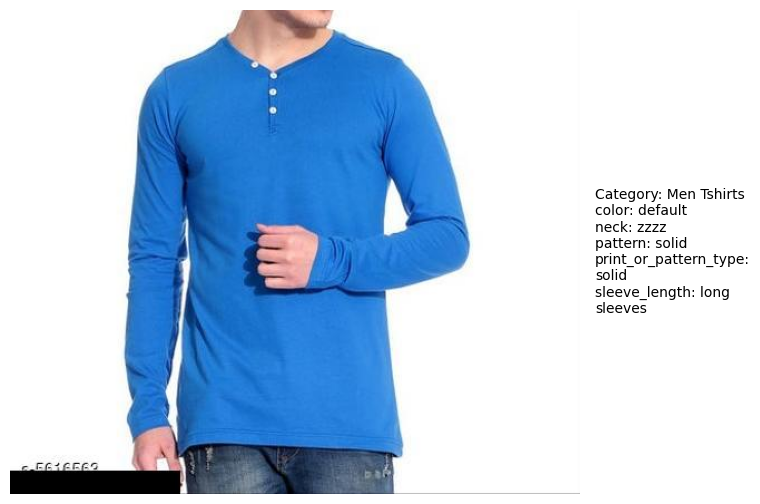

In [6]:
def plot_image_by_index(row_index, image_dir="/kaggle/input/visual-taxonomy/train_images/", df=train_df, category_dict=category_dict):
    # Set up plot
    fig, ax = plt.subplots(figsize=(6, 6))

    # Prepare image path
    row = df.iloc[row_index]
    img_id = str(row['id']).zfill(6)
    file_path = f"{image_dir}{img_id}.jpg"

    # Load image
    img = Image.open(file_path)

    # Display image
    ax.imshow(img)
    ax.axis('off')

    # Get category and attribute details if category_dict is provided
    if category_dict is not None:
        category = row['Category']
        attribute_names = category_dict[category]['attrs']
        num_attributes = category_dict[category]['num_attr']
        attribute_values = [row[f'attr_{j+1}'] for j in range(num_attributes)]
        attr_text = f"Category: {category}\n" + "\n".join(f"{name}: {value}" for name, value in zip(attribute_names, attribute_values))
        fig.text(1, 0.5, attr_text, ha='left', va='center', wrap=True, fontsize=10, color="black")

    plt.tight_layout()
    plt.show()
    
# missing_value_indices = train_df[train_df[config.target_cols].isna().any(axis=1)].index.tolist()
plot_image_by_index(24)

In [7]:
train , val = train_test_split(train_df , test_size = config.val_split , random_state=config.random_state)

In [8]:
class MultiOutputDataset(Dataset):
    def __init__(self, dataframe, image_col, target_cols,image_dir ,transform=None):
        self.dataframe = dataframe
        self.image_col = image_col
        self.target_cols = target_cols
        self.image_dir = image_dir
        self.transform = transform
    
        # Convert target columns to categorical codes
        self.id_2_labels = {}
        for col in self.target_cols:
            self.dataframe[col] = self.dataframe[col].astype('category')
            self.id_2_labels[col] = dict(enumerate(self.dataframe[col].cat.categories))
            self.dataframe[col] = self.dataframe[col].cat.codes

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx][self.image_col]
        img_id = self.pad_to_six_digits(img_id)
        img_path = f"{self.image_dir}{img_id}.jpg"
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        targets = [self.dataframe.iloc[idx][col] for col in self.target_cols]
        targets = torch.tensor(targets, dtype=torch.long)

        return image, targets
    def pad_to_six_digits(self , num):
        number_str = str(num)
        return number_str.zfill(6)

In [9]:
!pip install --upgrade albumentations
!pip install albumentations[imgaug]  # For additional augmenters if needed


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.7/680.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17


In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image

# Custom Albumentations Transform Wrapper
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img = np.array(img)
        # Apply Albumentations transformations
        transformed = self.transform(image=img)
        # Return the transformed image
        return transformed['image']

# Enhanced Training Augmentation Pipeline with Color Augmentations
train_transform = AlbumentationsTransform(
    A.Compose([
        A.Resize(256, 256),  # Resize the image to 256x256 pixels

        # Randomly crop a region of the image and resize it to 224x224
        A.RandomResizedCrop(224, 224, scale=(0.7, 1.0), ratio=(0.8, 1.2)),

        A.HorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a 50% chance

        # Apply one of the following augmentations
        A.OneOf([
            A.Emboss(p=0.3),    # Apply emboss effect
            A.Sharpen(p=0.3),   # Sharpen the image
            A.Blur(blur_limit=3, p=0.4)  # Apply blur with a maximum kernel size of 3
        ], p=0.5),

        # Randomly shift, scale, and rotate the image
        A.ShiftScaleRotate(
            shift_limit=0.05,   # Shift by up to 5% of the image size
            scale_limit=0.1,    # Scale by up to ±10%
            rotate_limit=15,    # Rotate by up to ±15 degrees
            p=0.5
        ),

        # Apply optical distortion
        A.OpticalDistortion(
            distort_limit=0.05,  # Limit the distortion
            shift_limit=0.05,    # Limit the shift
            p=0.3
        ),

        # Apply grid distortion
        A.GridDistortion(
            num_steps=5,         # Number of grid steps
            distort_limit=0.05,  # Limit the distortion
            p=0.3
        ),

        # Randomly shuffle grid blocks
        A.RandomGridShuffle(
            grid=(3, 3),  # Define a 3x3 grid
            p=0.2
        ),

        # Apply CoarseDropout to simulate Cutout
        A.CoarseDropout(
            max_holes=8,        # Maximum number of holes
            max_height=32,      # Maximum height of each hole
            max_width=32,       # Maximum width of each hole
            fill_value=0,       # Fill holes with black
            p=0.5
        ),

        # Another layer of CoarseDropout for added robustness
        A.CoarseDropout(
            max_holes=8,
            max_height=32,
            max_width=32,
            fill_value=0,
            p=0.5
        ),

        # **Added Color Augmentations**

        # Randomly adjust the brightness and contrast of the image
        A.RandomBrightnessContrast(
            brightness_limit=0.2,  # Adjust brightness by a factor of ±20%
            contrast_limit=0.2,    # Adjust contrast by a factor of ±20%
            p=0.5
        ),

        # Randomly shift the hue and saturation of the image
        A.HueSaturationValue(
            hue_shift_limit=20,        # Shift hue by ±20 degrees
            sat_shift_limit=30,        # Shift saturation by ±30
            val_shift_limit=20,        # Shift value (brightness) by ±20
            p=0.5
        ),

        # Apply color jitter to randomly change brightness, contrast, and saturation
        A.ColorJitter(
            brightness=0.2,    # Brightness factor
            contrast=0.2,      # Contrast factor
            saturation=0.2,    # Saturation factor
            hue=0.1,            # Hue factor
            p=0.5
        ),

        # Apply a random gamma correction
        A.RandomGamma(
            gamma_limit=(80, 120),  # Gamma value between 0.8 and 1.2
            p=0.5
        ),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),  # Enhance contrast

        # Normalize the image with ImageNet mean and std
        A.Normalize(
            mean=(0.485, 0.456, 0.406), 
            std=(0.229, 0.224, 0.225)
        ),

        ToTensorV2(),  # Convert the image to a PyTorch tensor
    ])
)

# Validation Augmentation Pipeline (No augmentations, only resizing and normalization)
val_transform = AlbumentationsTransform(
    A.Compose([
        A.Resize(224, 224),  # Resize the image to 224x224 pixels

        A.Normalize(
            mean=(0.485, 0.456, 0.406), 
            std=(0.229, 0.224, 0.225)
        ),

        ToTensorV2(),  # Convert the image to a PyTorch tensor
    ])
)


In [11]:
from torch.utils.data import DataLoader

# Create training dataset with augmentations
train_dataset = MultiOutputDataset(
    dataframe=train,
    image_col=config.image_col,
    target_cols=config.target_cols,
    image_dir=config.train_image_dir,
    transform=train_transform  # Apply training transforms
)

# Create validation dataset without augmentations
val_dataset = MultiOutputDataset(
    dataframe=val,
    image_col=config.image_col,
    target_cols=config.target_cols,
    image_dir=config.train_image_dir,
    transform=val_transform  # Apply validation transforms
)

# Create data loaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,               # Shuffle for training
    num_workers=4,              # Adjust based on your system
    pin_memory=True             # Use if training on GPU
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,              # No shuffling for validation
    num_workers=4,              # Adjust based on your system
    pin_memory=True             # Use if training on GPU
)


In [12]:
config.n_classes_list = [len(train_dataset.id_2_labels[attr]) for attr in train_dataset.id_2_labels.keys() ]
train_dataset.id_2_labels

{'attr_1': {0: 'black', 1: 'default', 2: 'multicolor', 3: 'white', 4: 'zzzz'},
 'attr_2': {0: 'polo', 1: 'round', 2: 'zzzz'},
 'attr_3': {0: 'printed', 1: 'solid', 2: 'zzzz'},
 'attr_4': {0: 'default', 1: 'solid', 2: 'typography', 3: 'zzzz'},
 'attr_5': {0: 'long sleeves', 1: 'short sleeves', 2: 'zzzz'}}

In [13]:
config.n_classes_list

[5, 3, 3, 4, 3]

In [14]:
val_dataset.id_2_labels

{'attr_1': {0: 'black', 1: 'default', 2: 'multicolor', 3: 'white', 4: 'zzzz'},
 'attr_2': {0: 'polo', 1: 'round', 2: 'zzzz'},
 'attr_3': {0: 'printed', 1: 'solid', 2: 'zzzz'},
 'attr_4': {0: 'default', 1: 'solid', 2: 'typography', 3: 'zzzz'},
 'attr_5': {0: 'long sleeves', 1: 'short sleeves', 2: 'zzzz'}}

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MMoE(nn.Module):
    def __init__(self, input_dim, num_experts, num_tasks, expert_dim):
        super(MMoE, self).__init__()
        self.num_tasks = num_tasks
        self.num_experts = num_experts
        self.expert_dim = expert_dim

        # Define expert networks
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, expert_dim),
                nn.ReLU(),
                nn.Dropout(0.5)
            ) for _ in range(num_experts)
        ])

        # Define gating networks for each task
        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, num_experts),
                nn.Softmax(dim=1)
            ) for _ in range(num_tasks)
        ])

    def forward(self, x):
        # Compute expert outputs
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # Shape: (batch_size, num_experts, expert_dim)

        # Compute gating weights for each task
        task_weights = [gate(x).unsqueeze(1) for gate in self.gates]  # List of (batch_size, 1, num_experts)

        # Compute weighted sum of experts for each task
        task_outputs = [torch.bmm(weight, expert_outputs).squeeze(1) for weight in task_weights]  # List of (batch_size, expert_dim)

        return task_outputs  # List of tensors, one per task


In [16]:
import torch
import torch.nn as nn


class MultiOutputClassifier(nn.Module):
    def __init__(self, n_classes_list, shared_hidden_size=2048, dropout_rate=0.5, reduction=16, num_experts=4, expert_dim=512):
        super(MultiOutputClassifier, self).__init__()
        
        # Load the pretrained Dinov2 backbone
        self.backbone = Dinov2Model.from_pretrained("facebook/dinov2-base")
        self.backbone.fc = nn.Identity()  # Remove the original classification head
        
        # Shared feature processing layers before MMoE
        self.shared_layers = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, shared_hidden_size),
            nn.BatchNorm1d(shared_hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(shared_hidden_size, expert_dim)
        )
        
        # Define MMoE layer
        self.mmoe = MMoE(input_dim=expert_dim, num_experts=num_experts, num_tasks=len(n_classes_list), expert_dim=expert_dim)
        
        # Output heads for each attribute
        self.output_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(expert_dim, expert_dim // 2),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(expert_dim // 2, n_classes)
            ) for n_classes in n_classes_list
        ])
    
    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone(x).pooler_output  # Shape: (batch_size, hidden_size)
        
        # Apply shared feature processing layers
        shared_features = self.shared_layers(features)  # Shape: (batch_size, expert_dim)
        
        # Apply MMoE to get task-specific features
        task_features = self.mmoe(shared_features)  # List of (batch_size, expert_dim)
        
        # Generate outputs for each attribute
        outputs = [head(task_feature) for head, task_feature in zip(self.output_heads, task_features)]
        
        return outputs


In [17]:
device = "cuda"
model = MultiOutputClassifier(config.n_classes_list).to(device)
criterion = nn.CrossEntropyLoss()
# Define the optimizer with AdamW and different learning rates
optimizer = optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': 1e-4}
], lr=1e-3)



config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [18]:
if config.load_model_from_check_point:
    model.load_state_dict(best_model_wts)

In [19]:
import os

# Set CUDA_LAUNCH_BLOCKING for better debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [20]:
train_dataset[64]

(tensor([[[ 1.3584,  1.3584,  1.3584,  ...,  1.3584,  1.3584,  1.3584],
          [ 1.3584,  1.3584,  1.3584,  ...,  1.3584,  1.3584,  1.3584],
          [ 1.3584,  1.3584,  1.3584,  ...,  1.3584,  1.3584,  1.3584],
          ...,
          [ 1.3584,  1.3584,  1.3584,  ..., -2.0665, -2.0665, -2.0665],
          [ 1.3584,  1.3584,  1.3584,  ..., -2.0665, -2.0665, -2.0665],
          [ 1.3584,  1.3584,  1.3584,  ..., -2.0665, -2.0665, -2.0665]],
 
         [[ 1.5182,  1.5182,  1.5182,  ...,  1.5182,  1.5182,  1.5182],
          [ 1.5182,  1.5182,  1.5182,  ...,  1.5182,  1.5182,  1.5182],
          [ 1.5182,  1.5182,  1.5182,  ...,  1.5182,  1.5182,  1.5182],
          ...,
          [ 1.5182,  1.5182,  1.5182,  ..., -1.9832, -1.9832, -1.9832],
          [ 1.5182,  1.5182,  1.5182,  ..., -1.9832, -1.9832, -1.9832],
          [ 1.5182,  1.5182,  1.5182,  ..., -1.9832, -1.9832, -1.9832]],
 
         [[ 1.7337,  1.7337,  1.7337,  ...,  1.7337,  1.7337,  1.7337],
          [ 1.7337,  1.7337,

In [21]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

# Assuming scheduler is defined as ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.1, 
    patience=5, 
    verbose=True
)

best_model_wts = copy.deepcopy(model.state_dict())
best_f1_score = 0.0

for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{config.epochs}"):
        images = images.to(device)
        targets = [target.to(device, dtype=torch.long) for target in targets.T]

        optimizer.zero_grad()
        outputs = model(images)

        loss = sum([criterion(output, target) for output, target in zip(outputs, targets)])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_targets = [[] for _ in range(len(config.n_classes_list))]
    all_preds = [[] for _ in range(len(config.n_classes_list))]
    with torch.no_grad():
        for images, targets in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}/{config.epochs}"):
            images = images.to(device)
            targets = [target.to(device, dtype=torch.long) for target in targets.T]

            outputs = model(images)
            loss = sum([criterion(output, target) for output, target in zip(outputs, targets)])
            val_loss += loss.item()

            for i, (output, target) in enumerate(zip(outputs, targets)):
                preds = torch.argmax(output, dim=1).cpu().numpy()
                all_preds[i].extend(preds)
                all_targets[i].extend(target.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    f1_scores = [
        f1_score(all_targets[i], all_preds[i], average='weighted') 
        for i in range(len(config.n_classes_list))
    ]
    avg_f1_score = sum(f1_scores) / len(f1_scores)
    print(f"Epoch {epoch+1}/{config.epochs}, Val Loss: {avg_val_loss:.4f}, F1 Score: {avg_f1_score:.4f}")

    # Step the scheduler with the validation F1 score
    scheduler.step(avg_f1_score)

    # Save the best model based on F1 score
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss
        }, config.model_check_point)
        print(f"Best model saved at epoch {epoch+1} with F1 Score: {avg_f1_score:.4f}")

print("Training Complete!")


Training Epoch 1/25: 100%|██████████| 80/80 [02:03<00:00,  1.54s/it]


Epoch 1/25, Train Loss: 6.1897


Validation Epoch 1/25: 100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


Epoch 1/25, Val Loss: 6.0300, F1 Score: 0.4038
Best model saved at epoch 1 with F1 Score: 0.4038


Training Epoch 2/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 2/25, Train Loss: 6.0831


Validation Epoch 2/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 2/25, Val Loss: 5.9248, F1 Score: 0.4315
Best model saved at epoch 2 with F1 Score: 0.4315


Training Epoch 3/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 3/25, Train Loss: 6.0259


Validation Epoch 3/25: 100%|██████████| 35/35 [00:17<00:00,  2.01it/s]


Epoch 3/25, Val Loss: 6.1735, F1 Score: 0.3290


Training Epoch 4/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 4/25, Train Loss: 6.0087


Validation Epoch 4/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 4/25, Val Loss: 5.9790, F1 Score: 0.4807
Best model saved at epoch 4 with F1 Score: 0.4807


Training Epoch 5/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 5/25, Train Loss: 5.9943


Validation Epoch 5/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 5/25, Val Loss: 5.7264, F1 Score: 0.4261


Training Epoch 6/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 6/25, Train Loss: 5.9922


Validation Epoch 6/25: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


Epoch 6/25, Val Loss: 5.8924, F1 Score: 0.4354


Training Epoch 7/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 7/25, Train Loss: 5.9941


Validation Epoch 7/25: 100%|██████████| 35/35 [00:17<00:00,  2.01it/s]


Epoch 7/25, Val Loss: 5.6706, F1 Score: 0.4580


Training Epoch 8/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 8/25, Train Loss: 5.9533


Validation Epoch 8/25: 100%|██████████| 35/35 [00:17<00:00,  2.01it/s]


Epoch 8/25, Val Loss: 5.8607, F1 Score: 0.4540


Training Epoch 9/25: 100%|██████████| 80/80 [02:02<00:00,  1.54s/it]


Epoch 9/25, Train Loss: 6.0925


Validation Epoch 9/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 9/25, Val Loss: 5.8265, F1 Score: 0.4399


Training Epoch 10/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 10/25, Train Loss: 6.0288


Validation Epoch 10/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 10/25, Val Loss: 5.9854, F1 Score: 0.4492


Training Epoch 11/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 11/25, Train Loss: 5.9601


Validation Epoch 11/25: 100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


Epoch 11/25, Val Loss: 5.7353, F1 Score: 0.4620


Training Epoch 12/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 12/25, Train Loss: 5.9308


Validation Epoch 12/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 12/25, Val Loss: 5.6668, F1 Score: 0.4688


Training Epoch 13/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 13/25, Train Loss: 5.9351


Validation Epoch 13/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 13/25, Val Loss: 5.7507, F1 Score: 0.4659


Training Epoch 14/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 14/25, Train Loss: 5.9229


Validation Epoch 14/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 14/25, Val Loss: 5.7223, F1 Score: 0.4702


Training Epoch 15/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 15/25, Train Loss: 5.8963


Validation Epoch 15/25: 100%|██████████| 35/35 [00:17<00:00,  2.01it/s]


Epoch 15/25, Val Loss: 5.6545, F1 Score: 0.4681


Training Epoch 16/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 16/25, Train Loss: 5.9097


Validation Epoch 16/25: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


Epoch 16/25, Val Loss: 5.6988, F1 Score: 0.4696


Training Epoch 17/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 17/25, Train Loss: 5.9045


Validation Epoch 17/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 17/25, Val Loss: 5.6665, F1 Score: 0.4725


Training Epoch 18/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 18/25, Train Loss: 5.8967


Validation Epoch 18/25: 100%|██████████| 35/35 [00:17<00:00,  2.01it/s]


Epoch 18/25, Val Loss: 5.6552, F1 Score: 0.4680


Training Epoch 19/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 19/25, Train Loss: 5.8952


Validation Epoch 19/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 19/25, Val Loss: 5.6570, F1 Score: 0.4678


Training Epoch 20/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 20/25, Train Loss: 5.8958


Validation Epoch 20/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 20/25, Val Loss: 5.6784, F1 Score: 0.4706


Training Epoch 21/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 21/25, Train Loss: 5.8866


Validation Epoch 21/25: 100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


Epoch 21/25, Val Loss: 5.6810, F1 Score: 0.4713


Training Epoch 22/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 22/25, Train Loss: 5.8942


Validation Epoch 22/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 22/25, Val Loss: 5.6395, F1 Score: 0.4669


Training Epoch 23/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 23/25, Train Loss: 5.8909


Validation Epoch 23/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 23/25, Val Loss: 5.6616, F1 Score: 0.4670


Training Epoch 24/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 24/25, Train Loss: 5.8946


Validation Epoch 24/25: 100%|██████████| 35/35 [00:17<00:00,  2.01it/s]


Epoch 24/25, Val Loss: 5.6221, F1 Score: 0.4675


Training Epoch 25/25: 100%|██████████| 80/80 [02:02<00:00,  1.53s/it]


Epoch 25/25, Train Loss: 5.8847


Validation Epoch 25/25: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]

Epoch 25/25, Val Loss: 5.6223, F1 Score: 0.4675
Training Complete!


In [ ]:
torch.save({'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': running_loss},config.model_check_point )

In [ ]:
def load_model_checkpoint(checkpoint_path, model, optimizer=None):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Model loaded from checkpoint '{checkpoint_path}' at epoch {epoch} with loss {loss:.4f}")
    return model, optimizer

model1 = MultiOutputClassifier(config.n_classes_list).to(device)
model1 , _ = load_model_checkpoint(config.model_check_point , model1)



In [ ]:
!ls /kaggle/working/


In [ ]:
%%time 
def evaluate_val_dataset(model, val_dataloader, n_classes_list):
    model.eval()
    all_targets = [[] for _ in range(len(n_classes_list))]
    all_preds = [[] for _ in range(len(n_classes_list))]

    with torch.no_grad():
        for images, targets in tqdm(val_dataloader, desc="Evaluating Validation Dataset"):
            images = images.to(device)
            targets = [target.to(device) for target in targets.T]

            outputs = model(images)
            for i, (output, target) in enumerate(zip(outputs, targets)):
                preds = torch.argmax(output, dim=1).cpu().numpy()
                all_preds[i].extend(preds)
                all_targets[i].extend(target.cpu().numpy())

    harmonic_means = []
    for i in range(len(n_classes_list)):
        macro_f1 = f1_score(all_targets[i], all_preds[i], average='macro')
        micro_f1 = f1_score(all_targets[i], all_preds[i], average='micro')
        attribute_f1_score = 2 * (macro_f1 * micro_f1) / (macro_f1 + micro_f1 + 1e-8)
        harmonic_means.append(attribute_f1_score)
        print(f"Attribute {i+1}: Macro F1 = {macro_f1:.4f}, Micro F1 = {micro_f1:.4f}, Harmonic Mean = {attribute_f1_score:.4f}")

    avg_category_scores = np.mean(harmonic_means)
    print(f"Average Score across all attributes: {avg_category_scores:.4f}")

    return avg_category_scores

# Evaluate the model on the validation dataset
evaluate_val_dataset(model1, val_dataloader, config.n_classes_list)
